In [1]:
using Gadfly
using Vec, LinearAlgebra
using GridWorldPathFollowing

┌ Info: Recompiling stale cache file /Users/kyle/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190


In [2]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
# action_sequence = [DOWN,RIGHT,UP,RIGHT,RIGHT,RIGHT,DOWN,DOWN,LEFT,UP,LEFT,DOWN,LEFT,LEFT]
action_sequence = [RIGHT,UP,RIGHT]
cell_width = 1.0
transition_time = 2.0
grid_path = construct_grid_world_path(start_pt,start_time,
    action_sequence,cell_width,transition_time)

traj = construct_trajectory(grid_path)
verify(traj)

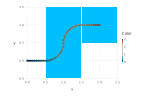

In [3]:
Δt = 0.01
t_range = get_start_time(traj):Δt:get_end_time(traj)
t_color_range = get_start_time(traj):(10*Δt):get_end_time(traj)
pad = 0.01
plot1 = plot(
    layer(
        x=[get_position(traj,t).x for t in t_range],
        y=[get_position(traj,t).y for t in t_range],
        Geom.path,
        Theme(default_color="black")
        ),
    layer(
        x=[get_position(traj,t).x for t in t_color_range],
        y=[get_position(traj,t).y for t in t_color_range],
        color=[get_dist(traj,t) for t in t_color_range],
        Geom.point
        ),
    layer(
        xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        Geom.rect
    ),
    Coord.cartesian(fixed=true)
)

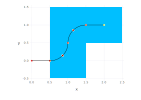

In [4]:
Δt = 0.01
t_range = get_start_time(traj):Δt:get_end_time(traj)
t_color_range = get_start_time(traj):(10*Δt):get_end_time(traj)
pad = 0.01
plot2 = plot(
    layer(
        x=[get_position(traj,t).x for t in t_range],
        y=[get_position(traj,t).y for t in t_range],
        Geom.path,
        Theme(default_color="black")
        ),
    layer(
        x=[get_start_pt(seg).x for seg in traj.segments],
        y=[get_start_pt(seg).y for seg in traj.segments],
        Geom.point,
        Theme(default_color="red")
        ),
    layer(
        x=[get_end_pt(seg).x for seg in traj.segments],
        y=[get_end_pt(seg).y for seg in traj.segments],
        Geom.point,
        Theme(default_color="yellow")
        ),
    layer(
        xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        Geom.rect
    ),
    Coord.cartesian(fixed=true)
)

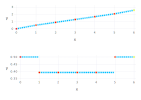

In [5]:
start_times = [get_start_time(seg) for seg in traj.segments]
final_times = [get_end_time(seg) for seg in traj.segments]
plot3 = plot(
    layer(x=start_times,y=[get_dist(traj,t) for t in start_times],Theme(default_color="red")),
    layer(x=final_times,y=[get_dist(traj,t) for t in final_times],Theme(default_color="yellow")),
    layer(x=collect(t_color_range),y=[get_dist(traj,t) for t in t_color_range])
)
plot4 = plot(
    layer(x=start_times,y=[norm(get_vel(traj,t)) for t in start_times],Theme(default_color="red")),
    layer(x=final_times,y=[norm(get_vel(traj,t)) for t in final_times],Theme(default_color="yellow")),
    layer(x=collect(t_color_range),y=[norm(get_vel(traj,t)) for t in t_color_range])
)
vstack(plot3,plot4)

# Optimize Velocity Profile
We apply a polynomial acceleration command in each time window

In [6]:
t_vec, accel, vel, pos = optimize_velocity_profile(traj)

([0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  4.875, 5.0, 5.125, 5.25, 5.375, 5.5, 5.625, 5.75, 5.875, 6.0], [1.6882, 1.37359, 1.05899, 0.744384, 0.429779, 0.115174, -0.19943, -0.514035, -0.618764, -0.513622  …  0.513623, 0.618767, 0.514034, 0.199429, -0.115175, -0.42978, -0.744384, -1.05899, -1.37359, -1.6882], [2.62592e-12, 0.211025, 0.382724, 0.515097, 0.608145, 0.661868, 0.676265, 0.651336, 0.587081, 0.509736  …  0.509736, 0.587082, 0.651336, 0.676265, 0.661868, 0.608145, 0.515097, 0.382724, 0.211025, 6.05102e-12], [-5.41579e-12, 0.013189, 0.0502983, 0.106412, 0.176615, 0.255991, 0.339624, 0.422599, 0.5, 0.568551  …  2.00225, 2.0708, 2.1482, 2.23117, 2.31481, 2.39418, 2.46438, 2.5205, 2.55761, 2.5708])

In [11]:
cum_d = cumsum([get_length(seg) for seg in traj.segments])
plot5 = vstack(
    plot(
        layer(x=t_vec[1:end-1],y=accel,Theme(default_color="green")),
        layer(x=t_vec[1:end-1],y=accel,Geom.step,Theme(default_color="green")),
        Guide.manual_color_key("",["accel"],["green"])
    ),
    plot(
        layer(x=t_vec,y=vel,Theme(default_color="red")),
        layer(x=t_vec,y=vel,Geom.step,Theme(default_color="red")),
        
        layer(x=t_vec,y=pos,Theme(default_color="blue")),
        layer(x=t_vec,y=pos,Geom.step,Theme(default_color="blue")),

        layer(x = t,y = [0, cum_d...],Geom.step,Theme(default_color="black")),
        Guide.manual_color_key("",["vel", "pos"],["red","blue"])
    )
)

UndefVarError: UndefVarError: t not defined